In [19]:
# # this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


# OLTraj Example 1: Plot Lagrangian trajectories

## Objective
To extract and plot trajectories (bkw and fwd) for a given date. 

## Input data: 
Any OLTraj file.

## Code:

Import needed modules

In [13]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from cartopy.util import add_cyclic_point

import matplotlib.colors as colors

import copy


Read chl data

In [14]:
fn = '/data/datasets/CCI/v4.2-release/climatology/ESACCI-OC-MAPPED-CLIMATOLOGY-1M_MONTHLY_4km_PML_OCx_QAA-05-fv4.2.nc'
dschl = xr.open_dataset(fn)
dschl.assign_coords(lon=(dschl.lon + 180)) # convert longitude to 0-360 degs
chl2plot = dschl['chlor_a']

Read Lagrangian trajectories

In [15]:
fnAV = '/data/datasets/Projects/OLTraj/From_AVISO/OLTraj/Processed/Lagrangian_traj/2008/20080501_oltraj_uv_global.nc'
dsAV = xr.open_dataset(fnAV)

In [16]:
#### convert longitude to -180,180 degs
new_lon = ((dsAV['lon'].values + 180) % 360) - 180
lon = np.append(new_lon[720:], new_lon[:720] )
dsAV['lon'] = lon

#### shift trajlon array
tmp = copy.deepcopy(dsAV['trajlon'].values)
# tmp2 = tmp[:,:,720:]
tmp2 = np.append(tmp[:,:,720:], tmp[:,:,   :720], axis=2)
dsAV['trajlon'][:,:,:] = tmp2

#### shift trajlat array
del tmp, tmp2
tmp = copy.deepcopy(dsAV['trajlat'].values)
# tmp2 = tmp[:,:,720:]
tmp2 = np.append(tmp[:,:,720:], tmp[:,:,   :720], axis=2)
dsAV['trajlat'][:,:,:] = tmp2


# plt.matshow(tmp2[28,::])
# plt.matshow(tmp[28,::])
# del new_lon, lon


Here `dsAV` contains `trajlon` and `trajlat` that are the variables containing the coordinates of the forward and backward trajectories for each grid point.

To visualize the initial positions, let's plot `trajlon` and `trajlat` at time-index 29 (i.e., that corresponding to the date in the filename.


**Initialize figure projection add initial points and continents**

In [17]:
# proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.Robinson(central_longitude = 200)

grid_skip = 20 # this is the stride for subsetting the data
it0 = 29 # this is the "time of the observation"

chl2plotE = chl2plot.sel(lon=slice(100, 180)).sel(lat=slice(-90, 90))
chl2plotW = chl2plot.sel(lon=slice(-180, -75)).sel(lat=slice(-90, 90))

new_lon = np.linspace(chl2plot.lon[0], chl2plot.lon[-1], 144 * 2)
new_lat = np.linspace(chl2plot.lat[0], chl2plot.lat[-1], 72 *2)
chl2ploti = chl2plot.interp(lat=new_lat, lon=new_lon)
data, lon = add_cyclic_point(chl2ploti, coord=chl2ploti['lon'])


# North Pacific (we need two parts because we are working across the 180degE meridian)
daAV = dsAV.sel(lon=slice(100, 180)).sel(lat=slice(-90, 90)) # subset geographic region of interest
daAVb = dsAV.sel(lon=slice(-180, -75)).sel(lat=slice(-90, 90)) # subset geographic region of interest

daAV_bkw = daAV.sel(time=slice( daAV.time[0], daAV.time[it0]  )) # subset backward trajectories
daAV_fwd = daAV.sel(time=slice( daAV.time[it0], daAV.time[-1]  )) # subset forward trajectories

daAVb_bkw = daAVb.sel(time=slice( daAVb.time[0], daAVb.time[it0]  )) # subset backward trajectories
daAVb_fwd = daAVb.sel(time=slice( daAVb.time[it0], daAVb.time[-1]  )) # subset forward trajectories




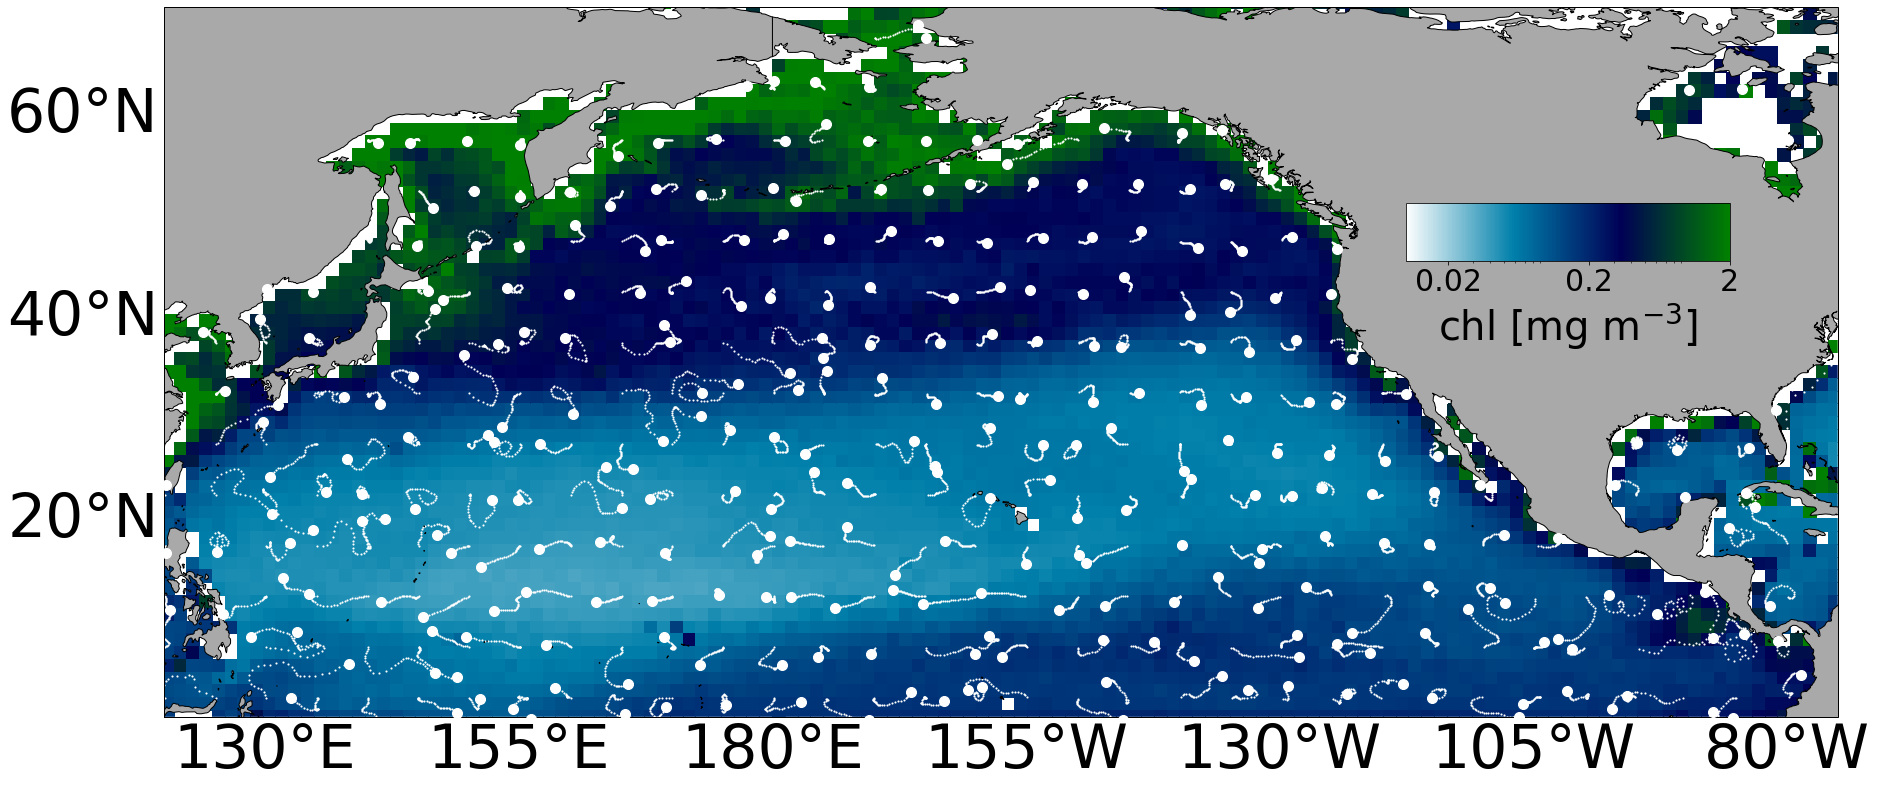

In [18]:

fig = plt.figure(figsize=(30,80))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180) )

CHL = ax.pcolormesh(  lon, chl2ploti['lat'], data[0], transform=ccrs.PlateCarree(), \
                linewidths=4, norm=colors.LogNorm(vmin=0.01, vmax=2), cmap =plt.get_cmap('ocean_r')) # cm.cm.ocean_r )
# add colorscale
cbaxes = fig.add_axes([0.7, 0.52, 0.15, 0.01]) 
cb = plt.colorbar(CHL, cax = cbaxes, orientation="horizontal", pad=0.03, ticks=[0.02, 0.2, 2])  
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
cb.set_label("$chl$ [mg m$^{-3}$]", fontsize=40, color='k')
cb.ax.set_xticklabels(['0.02', '0.2', '2'])  # horizontal colorbar
cb.ax.tick_params(labelsize=30)


for ilon in range(0, len(daAV_bkw.lon), grid_skip):
    for ilat in range(0, len(daAV_bkw.lat), grid_skip):
        # bwk trajs in black
#         ax.plot(daAV_bkw['trajlon'][:,ilat,ilon], daAV_bkw['trajlat'][:,ilat,ilon], 5 , color='b', linestyle='-', transform=ccrs.PlateCarree() )
        # fwd trajs in blue
        ax.scatter(daAV_fwd['trajlon'][:,ilat,ilon], daAV_fwd['trajlat'][:,ilat,ilon], 5 , color='w', marker='.', transform=ccrs.PlateCarree() )
ax.scatter(daAV['trajlon'][-1, ::grid_skip, ::grid_skip], daAV['trajlat'][-1, ::grid_skip, ::grid_skip], 100 ,'w', marker='o',  transform=ccrs.PlateCarree(), zorder=70 )

for ilon in range(0, len(daAVb_bkw.lon), grid_skip):
    for ilat in range(0, len(daAVb_bkw.lat), grid_skip):
        # bwk trajs in black
#         ax.plot(daAV_bkw['trajlon'][:,ilat,ilon], daAV_bkw['trajlat'][:,ilat,ilon], 5 , color='b', linestyle='-', transform=ccrs.PlateCarree() )
        # fwd trajs in blue
        ax.scatter(daAVb_fwd['trajlon'][:,ilat,ilon], daAVb_fwd['trajlat'][:,ilat,ilon], 5 , color='w', marker='.', transform=ccrs.PlateCarree() )        
ax.scatter(daAVb['trajlon'][-1, ::grid_skip, ::grid_skip], daAVb['trajlat'][-1, ::grid_skip, ::grid_skip], 100 ,'w', marker='o',  transform=ccrs.PlateCarree(), zorder=70 )







ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='darkgray'))
ax.set_extent([120, 285, 0, 70], ccrs.PlateCarree())
# ax.set_extent([-70, 10, -25, 25], ccrs.PlateCarree())
# ax.set_extent([-70, 10, 25, 65], ccrs.PlateCarree())
# ax.gridlines(draw_labels=True)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-80, -105, -130, -155, 180, 155, 130])
gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'fontsize': 60, 'color': 'k'}
gl.xlabel_style = {'fontsize': 60, 'color': 'k'}